In [1]:
import triton
import triton.language as tl
import torch
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'

# code

In [2]:
# @triton.autotune([triton.Config({}, num_stages=ns, num_warps=nw)
#                   for ns in [1,2,4]
#                   for nw in [1, 2,4,8,16]],
#                   key=['BLOCK_N'])
@triton.jit
def _short_softmax_fwd_kernel(X,
                          Y,
                          N,
                          BLOCK_N:tl.constexpr,
                          ):
    row_id = tl.cast(tl.program_id(0), tl.int64)

    X += row_id * N
    Y += row_id * N

    cols = tl.arange(0, BLOCK_N)
    x = tl.load(X + cols, mask=cols<N, other=float('-inf')).to(tl.float32)
    y = tl.softmax(x)
    tl.store(Y + cols, y, mask=cols<N)

# @triton.autotune([triton.Config({"BLOCK_N":bn}, num_stages=ns, num_warps=nw)
#                   for ns in [1,2,4]
#                   for nw in [4,8,16, 32]
#                   for bn in [4096, 8192]],
#                   key=['N'])
@triton.jit
def _long_softmax_fwd_kernel(X,
                          Y,
                          N,
                          BLOCK_N:tl.constexpr,
                          ):
    row_id = tl.cast(tl.program_id(0), tl.int64)

    X += row_id * N
    Y += row_id * N

    l_i = 0.
    m_i = float('-inf')
    for start in range(0, N, BLOCK_N):
        cols = start + tl.arange(0, BLOCK_N)
        x = tl.load(X + cols, mask=cols<N, other=float('-inf')).to(tl.float32)
        m_i_new = tl.maximum(m_i, tl.max(x))
        l_i = l_i * tl.exp(m_i - m_i_new) + tl.sum(tl.exp(x - m_i_new))
        m_i = m_i_new
    lse = m_i + tl.log(l_i)
    
    for start in range(0, N, BLOCK_N):
        cols = start + tl.arange(0, BLOCK_N)
        x = tl.load(X + cols, mask=cols<N, other=float('-inf')).to(tl.float32)
        y = tl.exp(x - lse)
        tl.store(Y + cols, y, mask=cols<N)

def softmax_fwd(x):
    M, N = x.shape
    P = 1024 * 16
    y = torch.empty_like(x)
    grid = (M,)
    if N <= P:
        BLOCK_N = triton.next_power_of_2(N)
        
        kwargs = {"num_warps": 16, "num_stages":1}
        if BLOCK_N <= 8192:
            kwargs = {"num_warps": 8, "num_stages":2}
        _short_softmax_fwd_kernel[grid](x, 
                                    y,
                                    N, 
                                    BLOCK_N,
                                    **kwargs
                                    )
    else:
        # BLOCK_N = 2048

        kwargs = {"BLOCK_N":8192, "num_warps": 16, "num_stages":1}
        _long_softmax_fwd_kernel[grid](x, 
                                    y,
                                    N, 
                                    # BLOCK_N,
                                    **kwargs
                                    )
    return y

# @triton.autotune([triton.Config({}, num_stages=ns, num_warps=nw)
#                   for ns in [1,2,4]
#                   for nw in [1, 2,4,8,16]],
#                   key=['BLOCK_N'])
@triton.jit
def _short_softmax_bwd_kernel(Y,
                              DY,
                              DX,
                              N,
                              BLOCK_N:tl.constexpr,
                          ):
    row_id = tl.cast(tl.program_id(0), tl.int64)

    DX += row_id * N
    DY += row_id * N
    Y += row_id * N

    cols = tl.arange(0, BLOCK_N)
    y = tl.load(Y + cols, mask=cols<N, other=0.).to(tl.float32)
    dy = tl.load(DY + cols, mask=cols<N, other=0.).to(tl.float32)
    ydy = y * dy
    dx = ydy - y * tl.sum(ydy)
    tl.store(DX + cols, dx, mask=cols<N)

# @triton.autotune([triton.Config({"BLOCK_N":bn}, num_stages=ns, num_warps=nw)
#                   for ns in [1,2,4]
#                   for nw in [4,8,16, 32]
#                   for bn in [4096, 8192]],
#                   key=['N'])
@triton.jit
def _long_softmax_bwd_kernel(Y,
                          DY,
                          DX,
                          N,
                          BLOCK_N:tl.constexpr,
                          ):
    row_id = tl.cast(tl.program_id(0), tl.int64)

    DX += row_id * N
    DY += row_id * N
    Y += row_id * N

    acc = 0.
    for start in range(0, N, BLOCK_N):
        cols = start + tl.arange(0, BLOCK_N)
        y = tl.load(Y + cols, mask=cols<N, other=0.).to(tl.float32)
        dy = tl.load(DY + cols, mask=cols<N, other=0.).to(tl.float32)
        acc += tl.sum(y * dy)

    for start in range(0, N, BLOCK_N):
        cols = start + tl.arange(0, BLOCK_N)
        y = tl.load(Y + cols, mask=cols<N, other=0.).to(tl.float32)
        dy = tl.load(DY + cols, mask=cols<N, other=0.).to(tl.float32)
        dx = y * dy - y * acc
        tl.store(DX + cols, dx, mask=cols<N)

def softmax_bwd(y, dy):
    M, N = y.shape
    P = 1024 * 16
    dx = torch.empty_like(y)
    grid = (M,)
    if N <= P:
        BLOCK_N = triton.next_power_of_2(N)
        
        kwargs = {"num_warps": 16, "num_stages":1}
        if BLOCK_N <= 8192:
            kwargs = {"num_warps": 4, "num_stages":2}
        _short_softmax_bwd_kernel[grid](y, 
                                    dy,
                                    dx,
                                    N, 
                                    BLOCK_N,
                                    **kwargs
                                    )
    else:
        # BLOCK_N = 2048

        kwargs = {"BLOCK_N":8192, "num_warps": 32, "num_stages":4}
        _long_softmax_bwd_kernel[grid](y, 
                                    dy,
                                    dx,
                                    N, 
                                    # BLOCK_N,
                                    **kwargs
                                    )
    return dx

class _SoftmaxFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x):
        y = softmax_fwd(x)
        ctx.y = y
        return y
    
    @staticmethod
    def backward(ctx, dy):
        dx = softmax_bwd(ctx.y, dy)
        return dx

def triton_softmax(x:torch.Tensor, dim=-1):
    # ndim = x.dim()
    # target_dim = dim if dim >=0 else ndim + dim
    # new_x = torch.movedim(x, target_dim, -1).contiguous()
    
    # input_shape = new_x.shape
    # new_x = new_x.view(-1, input_shape[-1])

    # p = _SoftmaxFunction.apply(new_x)
    # p = p.view(input_shape)
    # p = torch.movedim(p, -1, target_dim)
    p = _SoftmaxFunction.apply(x)
    return p

# 精度

In [3]:
x1 = torch.randn(1024, 1024 * 4, device='cuda', dtype=torch.bfloat16)
x1.requires_grad_(True)
x2 = deepcopy(x1)

y1 = triton_softmax(x1)
y2 = torch.softmax(x2, -1)
dy = torch.randn_like(y1)
y1.backward(dy)
y2.backward(dy)
print(torch.allclose(y1,y2, 1e-3, 1e-3))
print(torch.allclose(x1.grad, x2.grad, 1e-3, 1e-3))

True
True


# benchmark

## forward

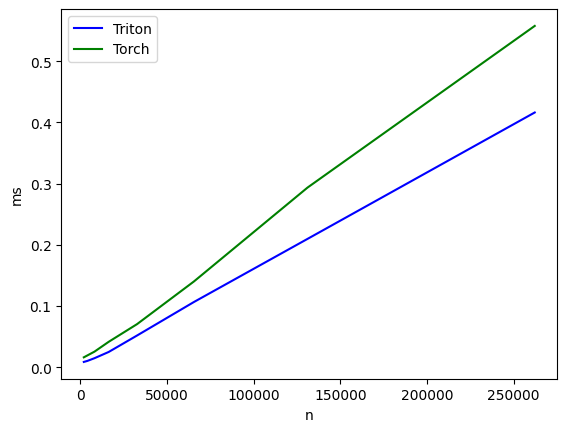

forward:
          n    Triton     Torch
0    2048.0  0.008703  0.016209
1    4096.0  0.010350  0.019312
2    8192.0  0.014772  0.025500
3   16384.0  0.024959  0.041543
4   32768.0  0.051884  0.070477
5   65536.0  0.106554  0.140087
6  131072.0  0.209674  0.293484
7  262144.0  0.416173  0.557591


In [7]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * 2**i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1024},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, n, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    x = torch.randn(b, n,device=device, dtype=dtype)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, -1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_softmax(x))
    return ms
benchmark.run(show_plots=True, print_data=True)

## backward

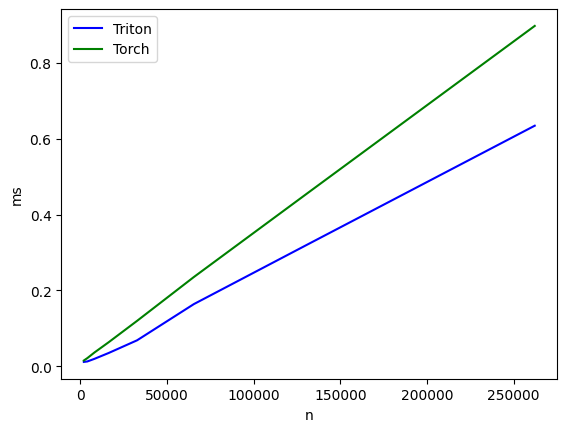

forward:
          n    Triton     Torch
0    2048.0  0.011272  0.014951
1    4096.0  0.012521  0.021378
2    8192.0  0.019422  0.036196
3   16384.0  0.034855  0.063226
4   32768.0  0.068298  0.119613
5   65536.0  0.163866  0.235319
6  131072.0  0.321053  0.456465
7  262144.0  0.634442  0.897698


In [8]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * 2**i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1024},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, n, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    x = torch.randn(b, n,device=device, dtype=dtype)
    x.requires_grad_(True)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        y = torch.softmax(x, -1)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[x])
    if provider == 'triton':
        y = triton_softmax(x, -1)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[x])
    return ms
benchmark.run(show_plots=True, print_data=True)

## forward + backward

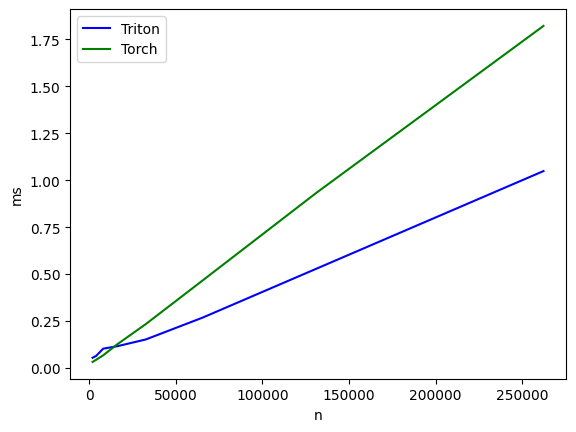

forward:
          n    Triton     Torch
0    2048.0  0.054842  0.032614
1    4096.0  0.064595  0.043876
2    8192.0  0.103255  0.068055
3   16384.0  0.116412  0.127051
4   32768.0  0.152264  0.234086
5   65536.0  0.268516  0.466311
6  131072.0  0.528474  0.932238
7  262144.0  1.048490  1.821155


In [9]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * 2**i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1024},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, n, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    x = torch.randn(b, n,device=device, dtype=dtype)
    x.requires_grad_(True)
    dy = torch.randn_like(x)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, -1).backward(dy))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_softmax(x).backward(dy), grad_to_none=[x])
    return ms
benchmark.run(show_plots=True, print_data=True)